# Project description
## A/B testing and analysis of results in a big online store

You are an analyst at a big online store. Together with the marketing department, you've compiled a list of hypotheses that may help boost revenue.

You need to prioritize these hypotheses, launch an A/B test, and analyze the results.


# Description of the data

***Data used in the first part of the project***

*/datasets/hypotheses_us.csv*

- **Hypotheses** — brief descriptions of the hypotheses
- **Reach** — user reach, on a scale of one to ten
- **Impact** — impact on users, on a scale of one to ten
- **Confidence** — confidence in the hypothesis, on a scale of one to ten
- **Effort** — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.

***Data used in the second part of the project***

*/datasets/orders_us.csv*

- **transactionId** — order identifier
- **visitorId** — identifier of the user who placed the order
- **date** — of the order
- **revenue** — from the order
- **group** — the A/B test group that the user belongs to

*/datasets/visits_us.csv*

- **date** — date
- **group** — A/B test group
- **visits** — the number of visits on the date specified in the A/B test group specified

## Download the data and prepare it for analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from datetime import timedelta
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.filterwarnings('ignore')

hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

In [2]:
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [3]:
hypotheses.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 1.6 KB


In [4]:
hypotheses.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'effort']

In [5]:
pd.options.display.max_colwidth = -1
hypotheses

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [6]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [8]:
orders.duplicated().sum()

0

In [9]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
#orders['date'] =  pd.to_datetime(orders['date'], format="%Y-%m-%d")

In [10]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
visits['date'] = visits['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [12]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [13]:
visits.duplicated().sum()

0

In [14]:
visitor_in_both_group = orders.groupby(['visitorId'])['group'].nunique().reset_index().query('group>1')
visitor_in_both_group.head()

,visitorId,group
2,8300375,2
44,199603092,2
51,232979603,2
55,237748145,2
66,276558944,2


In [15]:
visitor_in_both_group.shape[0]

58

In [16]:
orders_new = orders[~orders["visitorId"].isin(visitor_in_both_group["visitorId"])]
print("Size before:", orders.shape[0])
print("Size now:", orders_new.shape[0])

Size before: 1197
Size now: 1016


### Conclusion

- 3 data variables were created (hypotheses, orders, visits).
- There were no missing values in the data.
- There are no duplicates in the date.
- Rewrote column names in lowercase.
- Some of the columns contained date and time and were converted from object to_datetime.
- Removed visitors who fell into both group A and group B.

## Part 1. Prioritizing Hypotheses

***Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.***

In [17]:
hypotheses

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [18]:
hypotheses['ICE'] = hypotheses['impact'] * hypotheses['confidence'] / hypotheses['effort']

hypotheses[['hypothesis','ICE']].sort_values(by = 'ICE', ascending = False)

,hypothesis,ICE
8,Launch a promotion that gives users discounts on their birthdays,16.200000
0,Add two new channels for attracting traffic. This will bring 30% more users,13.333333
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.200000
6,Show banners with current offers and sales on the main page. This will boost conversion,8.000000
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.000000
1,Launch your own delivery service. This will shorten delivery time,2.000000
5,Add a customer review page. This will increase the number of orders,1.333333
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.125000
4,Change the background color on the main page. This will increase user engagement,1.000000


***Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority.***

In [19]:
hypotheses['RICE'] = hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence'] / hypotheses['effort']

hypotheses[['hypothesis','RICE']].sort_values(by = 'RICE', ascending = False)

,hypothesis,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,40.0
8,Launch a promotion that gives users discounts on their birthdays,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,9.0
1,Launch your own delivery service. This will shorten delivery time,4.0
5,Add a customer review page. This will increase the number of orders,4.0
4,Change the background color on the main page. This will increase user engagement,3.0


***Show how the prioritization of hypotheses changes when you use RICE instead of ICE. Provide an explanation for the changes.***

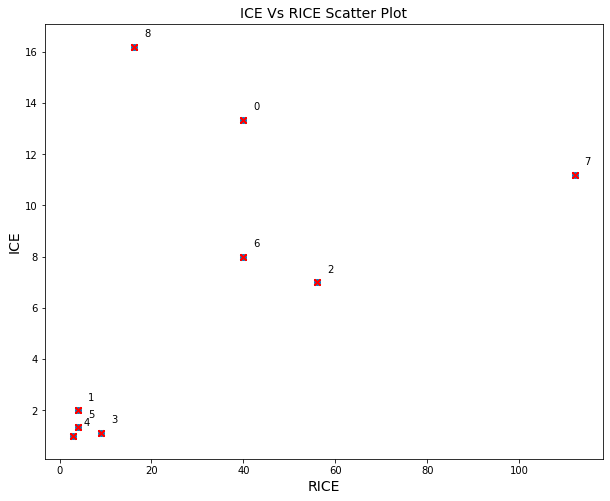

In [20]:
x = hypotheses['RICE'].values
y = hypotheses['ICE'].values
types = hypotheses.index.values

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x, y)

ax.set_xlabel('RICE', fontsize=14)
ax.set_ylabel('ICE', fontsize=14)
ax.set_title('ICE Vs RICE Scatter Plot', fontsize=14)

for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='red')

### Conclusion

- Based on the ICE framework, the 8-0-7-6-2 hypotheses win.
- Based on the RICE framework, the same hypotheses win as in the ICE framework, but the priority is already different: 7-2-0-6-8 (because the reach parameter for hypotheses 7 and 2 is high (10 and 8).
- From the graph, it can be seen that, hypothesis 7 scores higher in both ICE and RICE, hypothesis 8 only scores higher in ICE. Hypothesis 1,3,4, and 5 scores low in both ICE and RICE.



## Part 2. A/B Test Analysis

***1. Graph cumulative revenue by group. Make conclusions and conjectures.***

In [21]:
orders_new.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [22]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [23]:
datesGroups = orders_new[['date', 'group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [24]:
ordersAggregated = datesGroups.apply(
            lambda x: orders_new[
                np.logical_and(orders_new['date'] <= x['date'], 
                               orders_new['group'] == x['group'])]
                .agg({'date' : 'max', 
                      'group' : 'max', 
                      'transactionId' : pd.Series.nunique, 
                      'visitorId' : pd.Series.nunique, 
                      'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,2266.6
66,2019-08-01,B,17,17,967.2
175,2019-08-02,A,42,36,3734.9
173,2019-08-02,B,40,39,3535.3
291,2019-08-03,A,66,60,5550.1


In [25]:
visitsAggregated = datesGroups.apply(
            lambda x: visits[
                np.logical_and(visits['date'] <= x['date'], 
                               visits['group'] == x['group'])]
            .agg({'date' : 'max', 
                  'group' : 'max', 
                  'visits' : 'sum'}), axis=1).sort_values(by = ['date', 'group'])

visitsAggregated.head()

,date,group,visits
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [26]:
cumulativeData = ordersAggregated.merge(visitsAggregated, left_on = ['date', 'group'], right_on = ['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


In [27]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date','revenue', 'orders']]


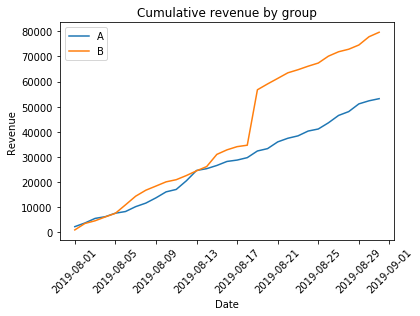

In [28]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=45)
plt.title('Cumulative revenue by group')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.legend()
plt.show()



**The graph shows that in group A the cumulative revenue is growing quite smoothly. In group B, until August 2019, there was the same situation, and then there was a sharp jump - this may indicate a sharp increase in the number of orders or the presence of very expensive orders on these dates.**

***2. Graph cumulative average order size by group. Make conclusions and conjectures.***

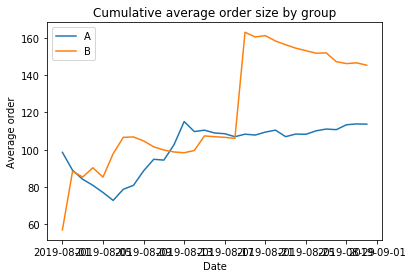

In [29]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label ='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label ='B')

plt.rcParams["figure.figsize"] = (8,6)
plt.title('Cumulative average order size by group')
plt.ylabel('Average order')
plt.xlabel('Date')
plt.legend()
plt.show()

**The average order size fluctuates a lot for both groups, although it becomes a bit stable towards the end of the test. Group B average order size is still higher than in group A, but it is declining for group B. The spike in group B in the middle of the test could be due to large and expensive orders.**

***3. Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.***

In [30]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
        left_on = 'date', right_on = 'date', 
        how='left', 
        suffixes=['A', 'B'])

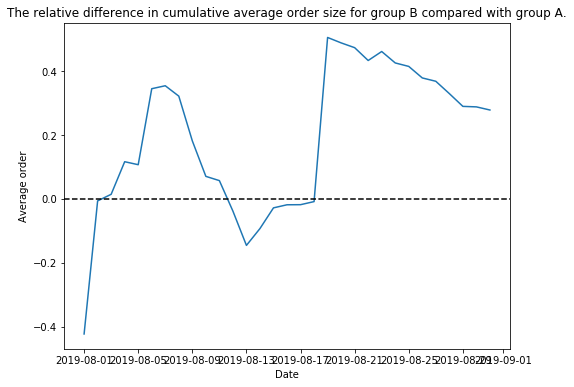

In [31]:
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--') 
plt.rcParams["figure.figsize"] = (15,6)
plt.title('The relative difference in cumulative average order size for group B compared with group A.')
plt.ylabel('Average order')
plt.xlabel('Date')

plt.show()

**The graph again shows strong fluctuations, which indicates that there are outliers in the data.**

***4. Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.***

In [32]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']
cumulativeData.head(3)


,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,2266.6,719,0.031989
1,2019-08-01,B,17,17,967.2,713,0.023843
2,2019-08-02,A,42,36,3734.9,1338,0.031390


In [33]:
cumulativeData.tail(3)

,date,group,orders,buyers,revenue,visitors,conversion
59,2019-08-30,B,531,511,77863.5,18198,0.029179
60,2019-08-31,A,468,445,53212.0,18736,0.024979
61,2019-08-31,B,548,528,79651.2,18916,0.028970


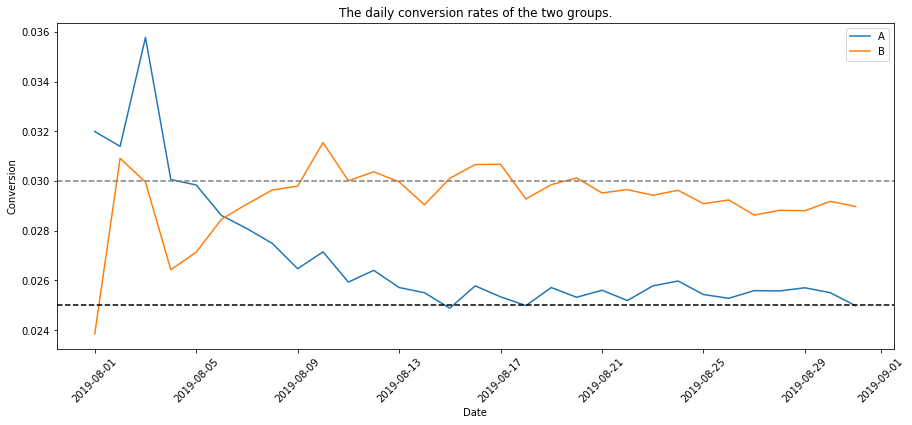

In [34]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.xticks(rotation=45)
plt.axhline(y=0.025, color='black', linestyle='--')
plt.axhline(y=0.03, color='grey', linestyle='--')
plt.title('The daily conversion rates of the two groups.')
plt.ylabel('Conversion')
plt.xlabel('Date')
plt.legend()
plt.show()

**At the begining of the test, the conversion rate of group A was higher. After few days, group B took over and lead till the end of the test. There were much fluctuations in the conversion rate but after August 17, 2019, conversion rates for both groups are fluctuating less than before.**


***5. Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.***

In [35]:
orders_new.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [36]:
ordersByUsers = (
    orders_new.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsers.columns = ['userId', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,userId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


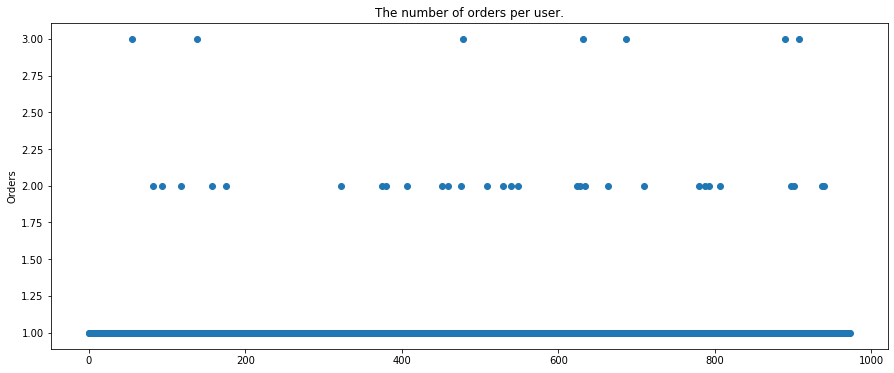

In [37]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 

plt.rcParams["figure.figsize"] = (15,6)
plt.title('The number of orders per user.')
plt.ylabel('Orders')

plt.show()

**Most of the buyers made 1 order. Based on the graph, can set a limit for anomalous orders between 2 and 3. Although orders 2 and 3 are not too extreme comparatively.**

***6. Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.***

In [38]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

**Not more than 5% of users ordered more than 1, and not more than 1% ordered more than 2. Hence filtering out 5% of observed values (deemed abnormal) means orders greater than 1.**

***7. Plot a scatter chart of order prices. Make conclusions and conjectures.***

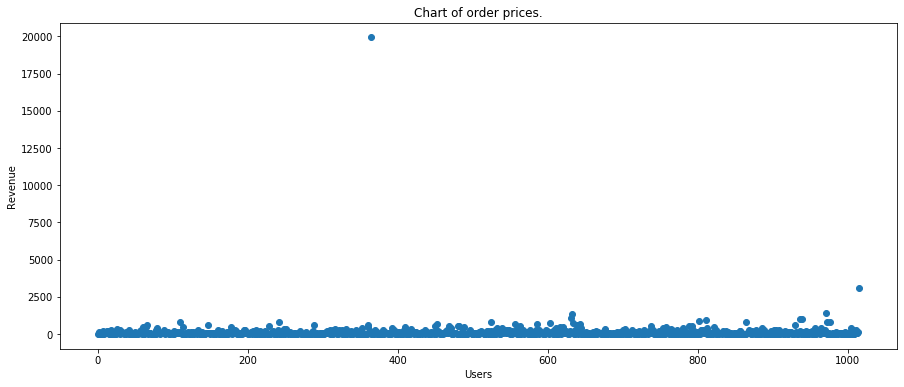

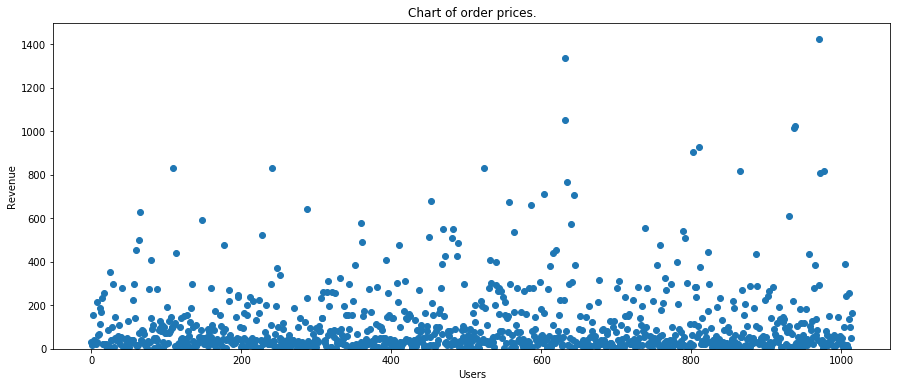

In [39]:
x_values = pd.Series(range(0,len(orders_new['revenue'])))
plt.scatter(x_values, orders_new['revenue'])

plt.rcParams["figure.figsize"] = (15,6)
plt.title('Chart of order prices.')
plt.ylabel('Revenue')
plt.xlabel('Users')
plt.show()

x_values = pd.Series(range(0,len(orders_new['revenue'])))
plt.scatter(x_values, orders_new['revenue'])

plt.rcParams["figure.figsize"] = (15,6)
plt.ylim(top=1500,bottom=0)
plt.title('Chart of order prices.')
plt.ylabel('Revenue')
plt.xlabel('Users')
plt.show()

**The first graph shows that there are two orders from 2,500 dollars to 20,000 dollars, these are outliers. The second graph shows that there are several orders more than 450 dollars, the rest of the purchases were up to this amount.**

***8. Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.***

In [40]:
print(np.percentile(orders_new['revenue'], [95, 99]))

[414.275 830.3  ]


**5% of shoppers placed orders over 414.2 dollars and 1% of shoppers placed orders over 830.3 dollars**



***9. Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.***

**Hypotheses:**


H0: There is no statistically significant difference in conversion between the groups.

H1: There is statistically significant difference in conversion between the groups.

Significance level (alpha) = 0.05

In [41]:
ordersByUsersA = orders_new[orders_new['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']
 
ordersByUsersB = orders_new[orders_new['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
    
ordersByUsersB.columns = ['userId', 'orders']

In [42]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)


In [43]:
print("P_value: {0:.4f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Relative Conversion rate: {0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

P_value: 0.0055
Relative Conversion rate: 0.160


**Significance level (alpha) = 0.05**

*The p-value is considerably lower than 0.05, so we reject the null hypothesis. The raw data analysis showed that the groups' conversion rates have statistically significant differences. The relative conversion gain for group B compared with group A is 16.0%.*

***10. Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.***

**Hypotheses:**

H0: There is no statistically significant difference in average order size between the groups.

H1: There is statistically significant difference in average order size between the groups.

Alpha = 0.05

In [44]:
print('P_value: {0:.3f}'.format(stats.mannwhitneyu(orders_new[orders_new['group']=='A']['revenue'], orders_new[orders_new['group']=='B']['revenue'])[1]))
print('Relative Conversion: {0:.3f}'.format(orders_new[orders_new['group']=='B']['revenue'].mean()/orders_new[orders_new['group']=='A']['revenue'].mean()-1)) 


P_value: 0.431
Relative Conversion: 0.278


**The p-value is greater than 0.05, so there are no statistically significant differences between the groups' average order sizes. Moreover, the relative difference is 27.8%.**

***11. Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.***

**Hypotheses:**

H0: There is no statistically significant difference in conversion between the groups.

H1: There is statistically significant difference in conversion between the groups.

Alpha = 0.05

In [45]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 1]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 1]['userId'],
    ],
    axis=0,
)
usersWithManyOrders.head()

36     366673373 
58     611059232 
64     678354126 
72     759473111 
171    1617417821
Name: userId, dtype: int64

In [46]:
usersWithExpensiveOrders = orders_new[orders_new['revenue'] > 10000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head(5)

33    249864742
36    366673373
51    406208401
67    522292794
58    611059232
dtype: int64

In [47]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - 
                                                          len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - 
                                                          len(ordersByUsersB['orders'])),name='orders')],axis=0)

In [48]:
print("P_value: {0:.5f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("Relative Conversion rate: {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

P_value: 0.00513
Relative Conversion rate: 0.181


**Based on the filtered data, there is significant difference between groups A and B. Hence, there is enough evidence to reject the null hypothesis that there no statistically significant difference in conversion between the groups. Therefore, group B's relative gain of about 18.1% is significant.**

***12. Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.***

**Hypotheses:**

H0: There is no statistically significant difference in average order size between the groups.

H1: There is statistically significant difference in average order size between the groups.

Alpha = 0.05

In [49]:
print('{0:.3f}'.format(stats.mannwhitneyu(
    orders_new[np.logical_and(
        orders_new['group']=='A',
        np.logical_not(orders_new['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders_new[np.logical_and(
        orders_new['group']=='B',
        np.logical_not(orders_new['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

0.445


In [50]:
print('{0:.3f}'.format(
    orders_new[np.logical_and(orders_new['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders_new[np.logical_and(
        orders_new['group']=='A',
        np.logical_not(orders_new['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 


-0.013


**Based on the filtered data, there is not a significant difference between groups A and B. A p_value of 0.445 is greater than 0.05. So we can't reject the null hypothesis that there's not a statistically significant difference in average order size between the groups. Also, there is a relative loss for group B (about 1.3%).**



***13. Make a decision based on the test results. The possible decisions are: 1. Stop the test, consider one of the groups the leader. 2. Stop the test, conclude that there is no difference between the groups. 3. Continue the test.***

**Based on the findings, the test should be stopped and Group B won. Since there is a statistically significant difference in conversion between groups, the relative increase in conversion of group B is about 17%.**

- There is a statistically significant difference in conversion between groups both on raw data and after filtering out anomalies.
- There is no statistically significant difference in average check between groups for both raw and cleaned data.
- The graph of the difference in conversion between groups shows that the results of group B are better than group A: they tend to increase and are practically fixed.
- The graph of the difference in the average check fluctuates. It is impossible to draw certain conclusions from this graph.